In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
# pd.__version__

In [3]:
# pip install --upgrade pandas

# Data Pre-processing

In [9]:
# all_train = pd.read_csv("datasets/toxic_train.csv")

In [10]:
# filter only toxic comments and convert comment_text to str

# toxic_only_train = all_train[all_train["target"] >= 0.5]
# toxic_only_train['comment_text'] = toxic_only_train['comment_text'].astype(str)

In [11]:
# shortlist only columns of interest only as well

# temp = toxic_only_train.iloc[:, :-13]
# toxic_only_train_shortlisted = temp.drop(temp.columns[[0, 1, 3, 4, 5, 6, 7]], axis = 1)
# toxic_only_train_shortlisted.head()

In [12]:
# assuming that if NaN for any category, probability of category = 0

# toxic_only_train_shortlisted.fillna(0, inplace = True)
# toxic_only_train_shortlisted.head()

In [13]:
# sum values for race, gender, religion and disabilities

# toxic_only_train_shortlisted["Race"] = toxic_only_train_shortlisted[["black", "white", "asian", "latino", "other_race_or_ethnicity"]].sum(axis = 1)
# toxic_only_train_shortlisted["Gender"] = toxic_only_train_shortlisted[["male", "female", "transgender", "other_gender", "heterosexual", "homosexual_gay_or_lesbian", "bisexual", "other_sexual_orientation"]].sum(axis = 1)
# toxic_only_train_shortlisted["Religion"] = toxic_only_train_shortlisted[["christian", "jewish", "muslim", "hindu", "atheist", "other_religion"]].sum(axis = 1)
# toxic_only_train_shortlisted["Disability"] = toxic_only_train_shortlisted[["intellectual_or_learning_disability", "other_disability", "physical_disability", "psychiatric_or_mental_illness"]].sum(axis = 1)

In [14]:
# drop identity columns after

# toxic_only_train_shortlisted.drop(toxic_only_train_shortlisted.iloc[:, 1:25], inplace = True, axis = 1)

In [15]:
# if all identities are 0, we will assume that attacks were not directed to any in particular and hence "None"

# toxic_only_train_shortlisted["target"] = np.where(toxic_only_train_shortlisted.iloc[:, 1:5].max(axis = 1) > 0, toxic_only_train_shortlisted.iloc[:, 1:5].idxmax(axis = 1), "None")

In [16]:
# drop sum columns for all identities

# toxic_only_train_shortlisted.drop(toxic_only_train_shortlisted.iloc[:, 1:5], inplace = True, axis = 1)

In [2]:
# preprocess text
# keep asterisks as they may be used to censor vulgar words

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import nltk
import re

# nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocesstext(text):
    text = text.lower() # convert everything to lower case first
    text = re.sub('(?:(?!\*)(?!\*)(?![a-zA-Z0-9]).)', ' ', text) # Removes special characters (except asterisk) and punctuations
    words = word_tokenize(text)
    words_without_stopwords = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    text = " ".join(words_without_stopwords)
    return text

In [18]:
# toxic_only_train_shortlisted["preprocessed_text"] = toxic_only_train_shortlisted["comment_text"].apply(preprocesstext)

In [19]:
# save files so that there's no need to preprocess again

# toxic_only_train_shortlisted.to_pickle('toxic_only_train_shortlisted_preprocessed.pkl')

In [2]:
# load preprocessed file

toxic_only_train_shortlisted = pd.read_pickle('./toxic_only_train_shortlisted_preprocessed.pkl')

In [3]:
toxic_only_train_shortlisted

,comment_text,target,preprocessed_text
4,haha you guys are a bunch of losers.,Disability,haha guy bunch loser
5,ur a sh*tty comment.,None,ur sh * tty comment
13,It's ridiculous that these guys are being call...,None,ridiculous guy called protester armed threat v...
14,This story gets more ridiculous by the hour! A...,None,story get ridiculous hour love people sending ...
19,"Angry trolls, misogynists and Racists"", oh my....",None,angry troll misogynist racist oh take 150 iq s...
...,...,...,...
1804825,Who is the jerk in the last row between the C ...,None,jerk last row c e
1804838,Nobody really cares that she supports the scie...,None,nobody really care support science behind glob...
1804856,Believing in God or not believing in God are p...,Religion,believing god believing god position held mill...
1804857,"I take your point, but I think you're shooting...",None,take point think shooting messenger police enf...


# Classification Models (Task 1)

In [4]:
from sklearn.model_selection import train_test_split

X = toxic_only_train_shortlisted["preprocessed_text"]
y = toxic_only_train_shortlisted["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train)
tfidf_test = tfidf_vec.transform(X_test)

In [9]:
# install yellowbrick for AUC ROC plot for multiclass

# !pip install yellowbrick

In [6]:
# for evaluation of performance

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [7]:
# to facilitate the plotting of ROCAUC curve

from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, classes=['Race', 'Gender', 'Religion', 'Disability', 'None'])
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

**Logistic Regression**

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
logreg = LogisticRegression(C = 5, random_state = 42, solver = 'sag', max_iter = 1000, n_jobs = -1)
logreg.fit(tfidf_train, y_train)
y_pred = logreg.predict(tfidf_test)

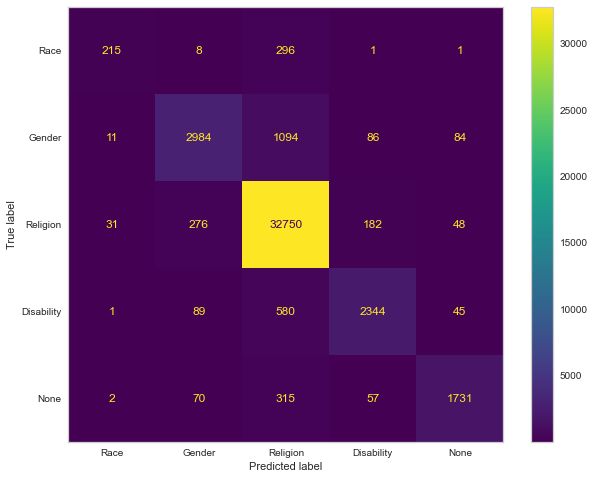

In [10]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(mat, display_labels=["Race", "Gender", "Religion", "Disability", "None"])
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Disability       0.83      0.41      0.55       521
      Gender       0.87      0.70      0.78      4259
        None       0.93      0.98      0.96     33287
        Race       0.88      0.77      0.82      3059
    Religion       0.91      0.80      0.85      2175

    accuracy                           0.92     43301
   macro avg       0.88      0.73      0.79     43301
weighted avg       0.92      0.92      0.92     43301



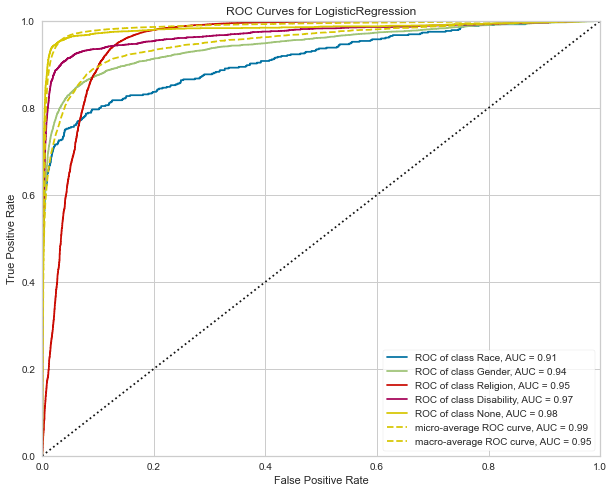

In [12]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(logreg, tfidf_train, y_train, tfidf_test, y_test)
plt.show()

In [21]:
# save logreg model

filename = "logreg_model.pkl"
pickle.dump(logreg, open(filename, "wb"))

**Multinomial NB**

In [8]:
from sklearn.naive_bayes import MultinomialNB

In [9]:
MLNB = MultinomialNB()
MLNB.fit(tfidf_train, y_train)
y_pred = MLNB.predict(tfidf_test)

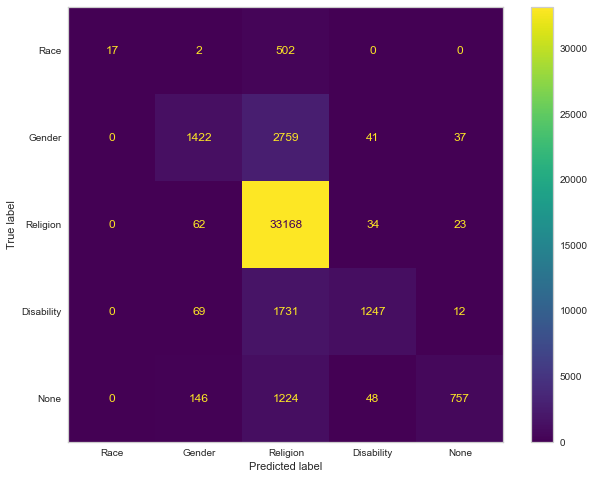

In [10]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(mat, display_labels=["Race", "Gender", "Religion", "Disability", "None"])
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Disability       1.00      0.03      0.06       521
      Gender       0.84      0.33      0.48      4259
        None       0.84      1.00      0.91     33287
        Race       0.91      0.41      0.56      3059
    Religion       0.91      0.35      0.50      2175

    accuracy                           0.85     43301
   macro avg       0.90      0.42      0.50     43301
weighted avg       0.85      0.85      0.81     43301



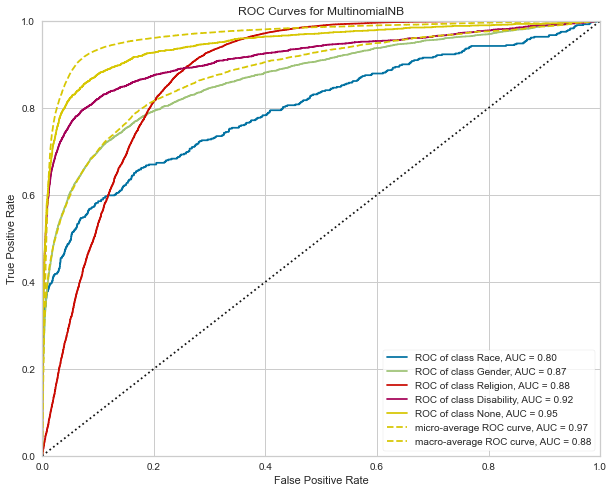

In [12]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(MLNB, tfidf_train, y_train, tfidf_test, y_test)
plt.show()

**LSTM**

In [122]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [48]:
X_test.to_numpy()

array(['crock deluded * would highly recommend person get hospital stat head removed buttock religious war islam islam even hatred israel america unite',
       'damned pleb told anymore merkel right need censor social medium give controlled view world start picking migrant libyan coast bringing italy really wonderful like anyone say jail cell',
       'serious mental illness look like paramilitary militia sovereign citizen sociopathic paranoic delusional criminal hysteria contagious degree armed dangerous',
       ...,
       'nanny state start child state know better idiot parent absolutely business municipal government employee elected official much cheer',
       'nothing near revolting south african',
       'man stand defend insult slander family child really man left really set tone called trump orange son feeble wife prostitute'],
      dtype=object)

In [55]:
train_sentence = []
for row in X_train.to_numpy():
    train_sentence.append(row)
train_sentence

['god best god fact god god ridiculous made rubbish though real know majority faith based follower even know history thier religion follow blindly look america headed back dark age',
 'ummm aware david sexually assaulted wife one loyal soldier turned pregnant soldier murdered conceal crime 2 samuel 11',
 'yep misogynistic sexist conservative fool',
 'wow know piece trivia mccain voted opening anwr wonder never came 2008 campaign course sarah palin ticket state would gone republican matter alaskan figure sarah truly idiot much later',
 'christianity different crusader slaughtered jew medieval era germany really christian spanish inquisition official executioner really christian protestant roman catholic bombed shot committed violence northern ireland really christian member kkk really christian yes heard argument sadly',
 'soft letting suit ruin life miserable system failed trying catch stain left monetary system oh well crappy unis wont fix problem fix nothing occupy movement soft guy 

In [56]:
test_sentence = []
for row in X_test.to_numpy():
    test_sentence.append(row)
test_sentence

['crock deluded * would highly recommend person get hospital stat head removed buttock religious war islam islam even hatred israel america unite',
 'damned pleb told anymore merkel right need censor social medium give controlled view world start picking migrant libyan coast bringing italy really wonderful like anyone say jail cell',
 'serious mental illness look like paramilitary militia sovereign citizen sociopathic paranoic delusional criminal hysteria contagious degree armed dangerous',
 'black fox news host receives death threat daring criticize trump fox like think williams little concerned dog lie fox gotten flea',
 'good old socialistic mother put bottled water folk business lose job import state another reason nutter must voted',
 'common sense untold thousand unemployed skilled trade people across canada think allowing canada compete job come good policy man canada doomed stupidity',
 'propaganda anti prostitutionist surprise really care would supporting passing hb112 make fe

In [59]:
max_words = 30000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(train_sentence)
sequences = tok.texts_to_sequences(train_sentence)
X_train_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
# oversample = SMOTE()
X_train_sequences_matrix

array([[    0,     0,     0, ...,    47,  1502,   700],
       [    0,     0,     0, ...,   223, 14765,  1122],
       [    0,     0,     0, ...,  1049,   183,    75],
       ...,
       [    0,     0,     0, ...,   516,  2428, 22891],
       [    0,     0,     0, ...,    84,    88,  1118],
       [    0,     0,     0, ...,   343,   127,  1174]])

In [60]:
tok.fit_on_texts(test_sentence)
sequences = tok.texts_to_sequences(test_sentence)
X_test_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
X_test_sequences_matrix

array([[   0,    0,    0, ...,  894,   82, 4260],
       [   0,    0,    0, ...,   20,  581, 2191],
       [   0,    0,    0, ..., 1229, 1443,  558],
       ...,
       [   0,    0,    0, ...,  899,   40, 3075],
       [   0,    0,    0, ..., 6010,  674, 1025],
       [   0,    0,    0, ..., 4683,  506, 2239]])

In [107]:
X_train_sequences_matrix.shape[0]

101033

In [106]:
y_train_2.shape

(101033, 5)

In [ ]:
# ["Race", "Gender", "Religion", "Disability", "None"]

In [124]:
y_train_2 = []
for i in y_train.to_numpy():
    if i=="Race":
        y_train_2.append([1,0,0,0,0])
    elif i=="Gender":
        y_train_2.append([0,1,0,0,0])
    elif i=="Religion":
        y_train_2.append([0,0,1,0,0])
    elif i=="Disability":
        y_train_2.append([0,0,0,1,0])
    else:
        y_train_2.append([0,0,0,0,1])
y_train_2 = np.array(y_train_2)

In [144]:
y_train_3 = []
for i in y_train.to_numpy():
    if i=="Race":
        y_train_3.append(1)
    elif i=="Gender":
        y_train_3.append(2)
    elif i=="Religion":
        y_train_3.append(3)
    elif i=="Disability":
        y_train_3.append(4)
    else:
        y_train_3.append(5)
y_train_3 = np.array(y_train_3)

In [182]:
y_test_2 = []
for i in y_test.to_numpy():
    if i=="Race":
        y_test_2.append([1,0,0,0,0])
    elif i=="Gender":
        y_test_2.append([0,1,0,0,0])
    elif i=="Religion":
        y_test_2.append([0,0,1,0,0])
    elif i=="Disability":
        y_test_2.append([0,0,0,1,0])
    else:
        y_test_2.append([0,0,0,0,1])
y_test_2 = np.array(y_test_2)

In [140]:
y_test_3 = []
for i in y_test.to_numpy():
    if i=="Race":
        y_test_3.append(1)
    elif i=="Gender":
        y_test_3.append(2)
    elif i=="Religion":
        y_test_3.append(3)
    elif i=="Disability":
        y_test_3.append(4)
    else:
        y_test_3.append(5)
y_test_3 = np.array(y_test_3)

In [183]:
y_test_2

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

In [152]:
model = Sequential()
model.add(Embedding(30000, 50, input_length=X_train_sequences_matrix.shape[1]))
model.add(LSTM(100,activation='tanh',recurrent_activation = "sigmoid", dropout=0.2, recurrent_dropout=0, unroll=False, use_bias=True, return_sequences=True))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train_sequences_matrix, y_train_2, epochs=3, batch_size=5)

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 200, 50)           1500000   
                                                                 
 lstm_44 (LSTM)              (None, 200, 100)          60400     
                                                                 
 flatten_10 (Flatten)        (None, 20000)             0         
                                                                 
 dense_44 (Dense)            (None, 5)                 100005    
                                                                 
Total params: 1,660,405
Trainable params: 1,660,405
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
20207/20207 [==============================] - 260s 13ms/step - loss: 0.3126 - accuracy: 0.9126
Epoch 2/3
20207/20207 [==============================] - 273s 14

In [154]:
scores = model.evaluate(X_test_sequences_matrix, y_test_2, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 66.53%


In [149]:
# model = Sequential()
# model.add(Embedding(30000, 50, input_length=X_train_sequences_matrix.shape[1]))
# model.add(LSTM(100,activation='tanh',recurrent_activation = "sigmoid", dropout=0.2, recurrent_dropout=0, unroll=False, use_bias=True, return_sequences=True))
# model.add(Flatten())
# model.add(Dense(1, activation='tanh'))
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())
# model.fit(X_train_sequences_matrix, y_train_3, epochs=3, batch_size=5)

In [155]:
y_pred = model.predict(X_test_sequences_matrix)

In [156]:
y_pred

array([[1.2441736e-04, 9.9907649e-01, 1.0777355e-05, 3.8684789e-06,
        7.8442192e-04],
       [1.3546893e-05, 3.6834357e-05, 4.2156125e-06, 7.2381126e-06,
        9.9993813e-01],
       [2.0613604e-04, 2.2701276e-03, 4.3753345e-04, 2.2973546e-03,
        9.9478889e-01],
       ...,
       [1.8180328e-04, 1.4269019e-03, 1.6155983e-04, 5.1429839e-04,
        9.9771547e-01],
       [1.6409747e-03, 5.7276627e-03, 5.7287165e-04, 2.1464790e-03,
        9.8991197e-01],
       [2.3904806e-03, 5.1191682e-01, 1.3365340e-04, 1.1472282e-04,
        4.8544434e-01]], dtype=float32)

In [157]:
y_pred_2 = []

for lst in y_pred:
    max_val = 0
    for i, val in enumerate(lst):
        if val>max_val:
            max_val=val
            ind=i
    y_pred_2.append(ind)
y_pred_2
 

[1,
 4,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 2,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 1,
 2,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 0,
 4,
 1,
 4,
 4,
 1,
 4,
 4,
 4,
 1,
 4,
 1,
 0,
 1,
 4,
 1,
 0,
 4,
 4,
 1,
 4,
 4,
 4,
 2,
 1,
 4,
 4,
 4,
 4,
 0,
 2,
 4,
 0,
 0,
 4,
 4,
 4,
 0,
 4,
 4,
 2,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 2,
 2,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 4,
 0,
 4,
 4,
 1,
 4,
 1,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 2,
 1,
 4,
 4,
 1,
 4,
 4,
 1,
 4,
 2,
 4,
 4,
 1,
 2,
 4,
 4,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 1,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 1,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 0,
 4,
 4,


In [161]:
y_pred_3 = []
for i in y_pred_2:
    if i==0:
        y_pred_3.append("Race")
    elif i==1:
        y_pred_3.append("Gender")
    elif i==2:
        y_pred_3.append("Religion")
    elif i==3:
        y_pred_3.append("Disability")
    else:
        y_pred_3.append("None")


In [162]:
y_pred_3

['Gender',
 'None',
 'None',
 'Race',
 'None',
 'Race',
 'None',
 'None',
 'None',
 'Religion',
 'None',
 'Gender',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Religion',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Gender',
 'None',
 'None',
 'None',
 'Gender',
 'Religion',
 'None',
 'None',
 'Race',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Religion',
 'None',
 'None',
 'None',
 'None',
 'Gender',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Gender',
 'Gender',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Religion',
 'None',
 'Race',
 'None',
 'Gender',
 'None',
 'None',
 'Gender',
 'None',
 'None',
 'None',
 'Gender',
 'None',
 'Gender',
 'Race',
 'Gender',
 'None',
 'Gender',
 'Race',
 'None',
 'None',
 'Gender',
 'None',
 'None',
 'None',
 'Religion',
 'Gender',
 'None',
 'None',
 'None',
 'None',
 'Race',
 'Religion',
 'None',
 'Race',
 'Race',
 'None

In [176]:
y_pred_4 = []
for i in y_pred_2:
    if i==0:
        y_pred_4.append([1,0,0,0,0])
    elif i==1:
        y_pred_4.append([0,1,0,0,0])
    elif i==2:
        y_pred_4.append([0,0,1,0,0])
    elif i==3:
        y_pred_4.append([0,0,0,1,0])
    else:
        y_pred_4.append([0,0,0,0,1])
y_pred_4 = np.array(y_pred_4)
y_pred_4

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

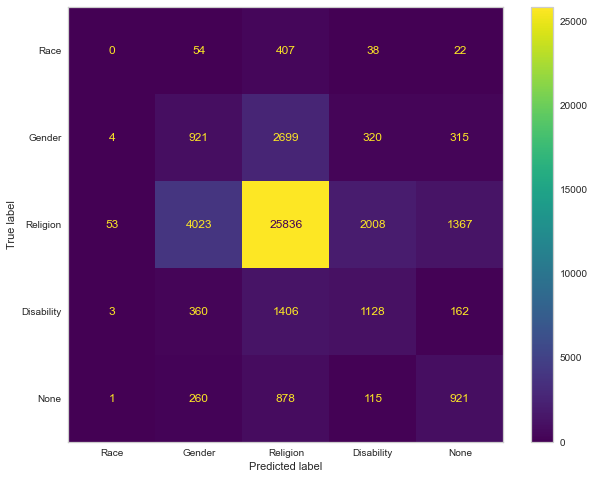

In [186]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred_3)
cmd = ConfusionMatrixDisplay(mat, display_labels=["Race", "Gender", "Religion", "Disability", "None"])
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

In [199]:
y_test_2

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

In [196]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc
# from sklearn.metrics import roc_auc_score
# nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred_3)
# auc_score1 = roc_auc_score(y_test, y_pred_3)
# random_probs = [0 for i in range(len(y_test))]
# p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
# plt.style.use('seaborn')
# # plot roc curves
# plt.plot(nn_fpr_keras, nn_tpr_keras, linestyle='--',color='orange', label='Neural Network')
# plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# # title
# plt.title('ROC curve')
# # x label
# plt.xlabel('False Positive Rate')
# # y label
# plt.ylabel('True Positive rate')

# plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
# plt.show();

C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\wei-d\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


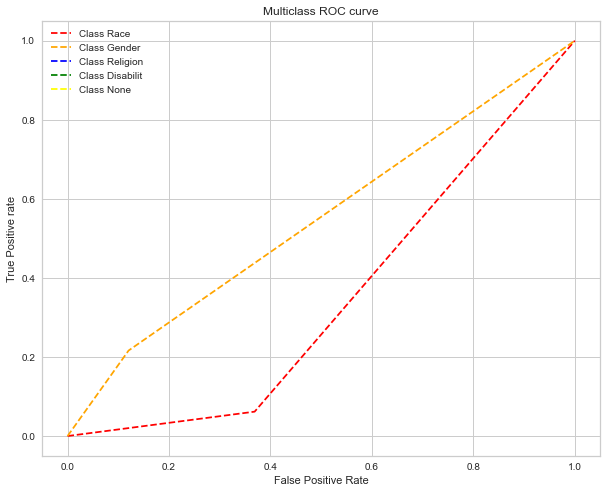

In [201]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc
# from sklearn.metrics import roc_auc_score
fpr = {}
tpr = {}
thresh ={}
n_class = ["Race", "Gender", "Religion", "Disability", "None"]
for i in range(len(n_class)):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_2[:,i], y_pred_4[:,i], pos_label=i)
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Class Race ')
plt.plot(fpr[1], tpr[1], linestyle='--',color='orange', label='Class Gender')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class Religion')
plt.plot(fpr[3], tpr[3], linestyle='--',color='green', label='Class Disabilit')
plt.plot(fpr[4], tpr[4], linestyle='--',color='yellow', label='Class None')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

# LDA (Task 2)

In [3]:
# !pip install pyLDAvis

In [14]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

**LDA Pre-Processing**

In [15]:
def lda_preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS:
            result.append(token)
    return result

In [16]:
lda_preprocessed_comments = toxic_only_train_shortlisted['preprocessed_text'].map(lda_preprocess)

**Gensim**

In [17]:
dictionary = corpora.Dictionary(lda_preprocessed_comments)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=75000)

In [18]:
bow_corpus = [dictionary.doc2bow(doc) for doc in lda_preprocessed_comments]
# tfidf = models.TfidfModel(bow_corpus)
# corpus_tfidf = tfidf[bow_corpus]

In [38]:
# find optimal k (no. of topics) and plot graph visually

from gensim.models import CoherenceModel

model_list = []
perplexity_values = []
coherence_values = []
model_topics = []

for i in range(2, 32, 2):
    print("--------Topics: " + str(i) +'----------')
    lda_model = models.LdaMulticore(bow_corpus, num_topics=i,id2word=dictionary, passes=2, workers=2)
#     lda_model.fit_transform(bow_corpus)
    model_topics.append(i)
    model_list.append(lda_model)
    perplexity_cal = lda_model.log_perplexity(bow_corpus)
    perplexity_values.append(perplexity_cal)
    print("#Topics: " + str(i) + ", Score: " + str(perplexity_cal))
    coherence_model_lda = models.CoherenceModel(model=lda_model, texts=lda_preprocessed_comments,dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    print("#Topics: " + str(i) + ', Coherence Score: ', coherence_lda)


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--------Topics: 2----------
#Topics: 2, Score: -8.262430474753822
#Topics: 2, Coherence Score:  0.2828999979655245
--------Topics: 4----------
#Topics: 4, Score: -8.322948213165944
#Topics: 4, Coherence Score:  0.3419585817879764
--------Topics: 6----------
#Topics: 6, Score: -8.357906916146783
#Topics: 6, Coherence Score:  0.399932322183858
--------Topics: 8----------
#Topics: 8, Score: -8.400906263157621
#Topics: 8, Coherence Score:  0.3756948113534644
--------Topics: 10----------
#Topics: 10, Score: -8.568061994256071
#Topics: 10, Coherence Score:  0.41302306004742684
--------Topics: 12----------
#Topics: 12, Score: -8.784875587556932
#Topics: 12, Coherence Score:  0.4198928288185832
--------Topics: 14----------
#Topics: 14, Score: -8.922705263154175
#Topics: 14, Coherence Score:  0.4309886266296206
--------Topics: 16----------
#Topics: 16, Score: -9.054463787138557
#Topics: 16, Coherence Score:  0.38290169388284967
--------Topics: 18----------
#Topics: 18, Score: -9.14758820538393


C:\Users\wei-d\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


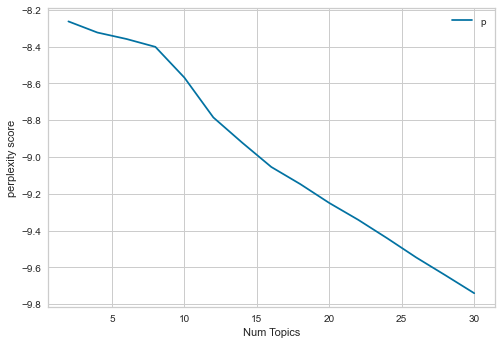

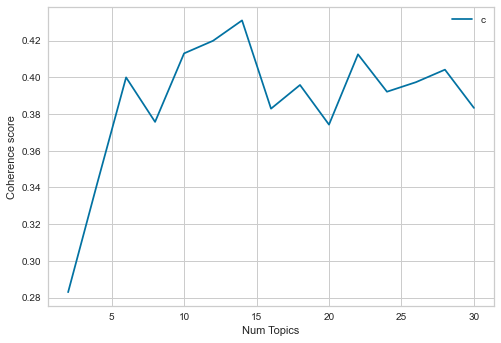

In [40]:
import matplotlib.pyplot as plt

limit=32; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()
limit=32; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

**Gensim Final model (14 Topics)**

In [19]:
lda_model = models.LdaMulticore(bow_corpus, num_topics=14,
                                    id2word=dictionary, passes=2, workers=2)

In [11]:
topics = lda_model.print_topics(num_topics=-1, num_words=5)
for i, topic in enumerate(topics):
    print("Train topic {}: {}".format(i, topic))

Train topic 0: (0, '0.030*"canadian" + 0.029*"canada" + 0.023*"liberal" + 0.022*"trudeau" + 0.018*"like"')
Train topic 1: (1, '0.019*"stupid" + 0.011*"time" + 0.009*"day" + 0.009*"clown" + 0.009*"like"')
Train topic 2: (2, '0.018*"tax" + 0.018*"money" + 0.012*"pay" + 0.011*"people" + 0.010*"government"')
Train topic 3: (3, '0.043*"idiot" + 0.025*"dumb" + 0.015*"right" + 0.014*"like" + 0.011*"dog"')
Train topic 4: (4, '0.027*"trump" + 0.024*"republican" + 0.024*"white" + 0.017*"party" + 0.017*"democrat"')
Train topic 5: (5, '0.028*"white" + 0.018*"people" + 0.014*"black" + 0.011*"right" + 0.009*"american"')
Train topic 6: (6, '0.022*"gun" + 0.017*"people" + 0.015*"criminal" + 0.012*"law" + 0.012*"kill"')
Train topic 7: (7, '0.014*"people" + 0.012*"like" + 0.010*"fake" + 0.009*"time" + 0.008*"stupid"')
Train topic 8: (8, '0.018*"comment" + 0.017*"people" + 0.012*"black" + 0.011*"like" + 0.011*"post"')
Train topic 9: (9, '0.014*"http" + 0.012*"drug" + 0.011*"com" + 0.010*"www" + 0.009*"de

In [12]:
# predict the type of topic for document (index 5)

bd5 = bow_corpus[5]
for i in range(len(bd5)):
    print("Word {} (\"{}\") appears {} time.".format(bd5[i][0], dictionary[bd5[i][0]],bd5[i][1]))

Word 50 ("act") appears 1 time.
Word 51 ("bash") appears 1 time.
Word 52 ("christian") appears 1 time.
Word 53 ("entire") appears 1 time.
Word 54 ("idiot") appears 1 time.
Word 55 ("muslim") appears 1 time.
Word 56 ("okay") appears 2 time.
Word 57 ("religion") appears 1 time.
Word 58 ("sect") appears 1 time.
Word 59 ("smear") appears 1 time.


In [13]:
for index, score in sorted(lda_model[bd5], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 5)))


Score: 0.42223891615867615	 
Topic: 0.021*"country" + 0.021*"muslim" + 0.013*"american" + 0.012*"terrorist" + 0.012*"war"

Score: 0.42028194665908813	 
Topic: 0.018*"comment" + 0.017*"people" + 0.012*"black" + 0.011*"like" + 0.011*"post"

Score: 0.0919780358672142	 
Topic: 0.043*"idiot" + 0.025*"dumb" + 0.015*"right" + 0.014*"like" + 0.011*"dog"


In [14]:
# the lower the better
print('Perplexity: ', round(lda_model.log_perplexity(bow_corpus), 2))

# the higher the better
coherence_model_lda = models.CoherenceModel(model=lda_model, texts=lda_preprocessed_comments, 
                                     dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Perplexity:  -8.69

Coherence Score:  0.526525582802584


In [15]:
lda_vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
lda_vis

C:\Users\DVH\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.067076  0.107955       1        1  11.830449
8      0.052510 -0.088832       2        1  10.965006
5      0.117707 -0.063949       3        1   9.167783
11     0.106667  0.075382       4        1   8.808425
7     -0.126618  0.038971       5        1   8.382242
10     0.102256 -0.056671       6        1   7.932496
4      0.186957  0.043330       7        1   7.445188
12    -0.048864 -0.204417       8        1   6.237335
1     -0.090739  0.114863       9        1   6.022937
6     -0.114279 -0.099189      10        1   5.870867
0     -0.020516  0.178143      11        1   4.822134
9     -0.166313 -0.062238      12        1   4.761462
3     -0.063836  0.029478      13        1   4.094923
13     0.132145 -0.012826      14        1   3.658753, topic_info=        Term          Freq         Total Category  logprob  loglift
465    trump  36063.000000  36063.000000  Default  30.0000  30.0000
64     woman   9043.000000   9043.000000  Default  29.0000  29.0000
163    white  15237.000000  15237.000000  Default  28.0000  28.0000
43    racist   8874.000000   8874.000000  Default  27.0000  27.0000
54     idiot   9675.000000   9675.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
1981  speech    413.960322   2025.073608  Topic14  -5.5884   1.7205
161    right    741.149160  14831.640674  Topic14  -5.0060   0.3117
89      need    594.316797  11335.770093  Topic14  -5.2268   0.3597
179    sound    349.575914   2311.355433  Topic14  -5.7575   1.4192
47      want    344.677988  11206.911454  Topic14  -5.7716  -0.1736

[1128 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
10167     13  0.981917      abc
6995       3  0.060714  abiding
6995       6  0.017347  abiding
6995       8  0.017347  abiding
6995      10  0.902038  abiding
...      ...       ...      ...
4717       4  0.992877    youtu
6728      12  0.995618  youtube
4950       2  0.194740      yup
4950       3  0.022470      yup
4950       9  0.775216      yup

[5095 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 6, 12, 8, 11, 5, 13, 2, 7, 1, 10, 4, 14])

In [16]:
def get_dominant_topics(lda_model, tpd, texts):

    arr = []
    
    # Get main topic in each document
    for i, row_list in enumerate(tpd):
        row = row_list[0] if lda_model.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic (which is the first element in row), Perc Contribution and Keywords for each document
        dominant = row[0]
        topic_keywords = ", ".join([word for word, prop in lda_model.show_topic(dominant[0])])
        arr.append([int(dominant[0]), round(dominant[1], 4), topic_keywords])
        
    dominant_topics_df = pd.DataFrame(arr, columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'], index=texts.index)
    merged = pd.concat([dominant_topics_df, texts], axis=1)
    merged.reset_index(inplace=True)
    merged.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    
    return merged

In [18]:
merged = get_dominant_topics(lda_model, lda_model[bow_corpus], lda_preprocessed_comments)
merged.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,4,3,0.4273,"idiot, dumb, right, like, dog, left, let, peop...","[haha, guy, bunch, loser]"
1,5,0,0.5219,"canadian, canada, liberal, trudeau, like, gove...","[ur, sh, tty, comment]"
2,13,10,0.7432,"country, muslim, american, terrorist, war, tru...","[ridiculous, guy, called, protester, armed, th..."
3,14,7,0.5302,"people, like, fake, time, stupid, need, news, ...","[story, ridiculous, hour, love, people, sendin..."
4,19,5,0.5625,"white, people, black, right, american, country...","[angry, troll, misogynist, racist, oh, iq, sla..."
5,31,10,0.4223,"country, muslim, american, terrorist, war, tru...","[muslim, act, pilloried, okay, smear, entire, ..."
6,34,8,0.3285,"comment, people, black, like, post, know, thin...","[bitch, nut, read, book, woman]"
7,84,9,0.2304,"http, drug, com, www, death, watch, like, na, ...","[tuesday, jan, member, socalled, militia, trav..."
8,105,7,0.5859,"people, like, fake, time, stupid, need, news, ...","[love, participate, portland, farmer, market, ..."
9,123,7,0.8020,"people, like, fake, time, stupid, need, news, ...","[took, opportunity, check, yard, floorpans, fi..."


In [19]:
merged.to_csv("dominant_topics.csv")

In [20]:
# save LDA model

lda_model.save("LDA_model.pkl")

**Sklearn**

In [10]:
lda_comments_joined = [" ". join(x) for x in list(lda_preprocessed_comments)]

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# TFIDF numerical representation
tfidf_vectoriser = TfidfVectorizer()
lda_tfidf_vecs = tfidf_vectoriser.fit_transform(lda_comments_joined)

# Count numerical representation
count_vectoriser = CountVectorizer()
lda_count_vecs = count_vectoriser.fit_transform(lda_comments_joined)

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# # LDA based on TFIDF (use this first because of the similar TFIDF representation used for Gensim)

# LDA_tfidf = LatentDirichletAllocation(n_jobs = -1)
# LDA_tfidf.fit(lda_tfidf_vecs)

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# LDA based on count

LDA_count = LatentDirichletAllocation(n_jobs = -1)
LDA_count.fit(lda_count_vecs)

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(n_jobs=-1)

In [19]:
# find optimal k (no. of topics) and plot graph visually

from gensim.models import CoherenceModel

model_list = []
perplexity_values = []
model_topics = []

for num_topics in range(2, 32, 2):
    comments_tfidf_lda_x = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = -1)
    comments_tfidf_lda_x.fit_transform(lda_tfidf_vecs)
    model_topics.append(num_topics)
    model_list.append(comments_tfidf_lda_x)
    perplexity_values.append(comments_tfidf_lda_x.perplexity(lda_tfidf_vecs))
    print("#Topics: " + str(num_topics) + ", Score: " + str(comments_tfidf_lda_x.perplexity(lda_tfidf_vecs)))


C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Topics: 2, Score: 11467.103682110997


PicklingError: Could not pickle the task to send it to the workers.

In [20]:
# find optimal k (no. of topics) and plot graph visually

from gensim.models import CoherenceModel

model_list = []
perplexity_values = []
model_topics = []

for num_topics in range(2, 32, 2):
    tfidf_lda_x = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = 1)
    tfidf_lda_x.fit_transform(lda_tfidf_vecs)
    model_topics.append(num_topics)
    model_list.append(tfidf_lda_x)
    perplexity_values.append(tfidf_lda_x.perplexity(lda_tfidf_vecs))
    print("#Topics: " + str(num_topics) + ", Score: " + str(tfidf_lda_x.perplexity(lda_tfidf_vecs)))


C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Topics: 2, Score: 11531.474062229849
#Topics: 4, Score: 16981.660047841182
#Topics: 6, Score: 23472.87965552742
#Topics: 8, Score: 26590.62466290091
#Topics: 10, Score: 34897.36153301647
#Topics: 12, Score: 35880.994059249264
#Topics: 14, Score: 41499.8207005717
#Topics: 16, Score: 49977.89635660024
#Topics: 18, Score: 58134.0879699394
#Topics: 20, Score: 47229.40343558812
#Topics: 22, Score: 53119.13284206326
#Topics: 24, Score: 57039.72010882239
#Topics: 26, Score: 49940.154040927475
#Topics: 28, Score: 70850.61069903518
#Topics: 30, Score: 170592.89536447893


C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


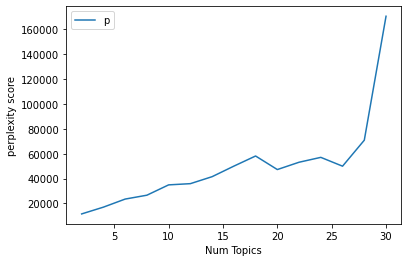

In [21]:
import matplotlib.pyplot as plt

limit=32; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [24]:
lda_count_vecs

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<144334x68565 sparse matrix of type '<class 'numpy.int64'>'
	with 2826584 stored elements in Compressed Sparse Row format>

In [27]:

from gensim.models import CoherenceModel

model_list = []
perplexity_values = []
model_topics = []

for num_topics in range(2, 32, 2):
    count_lda_x = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = 1)
    count_lda_x.fit_transform(lda_count_vecs)
    model_topics.append(num_topics)
    model_list.append(count_lda_x)
    perplexity_values.append(count_lda_x.perplexity(lda_count_vecs))
    print("#Topics: " + str(num_topics) + ", Score: " + str(count_lda_x.perplexity(lda_count_vecs)))
#     coherence_model_lda = models.CoherenceModel(model=count_lda_x, texts=lda_preprocessed_comments,dictionary=dictionary, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     coherence_values.append(coherence_lda)
#     print("#Topics: " + str(i) + ', Coherence Score: ', coherence_lda)

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Topics: 2, Score: 4747.735022624461
#Topics: 4, Score: 4954.299928405188
#Topics: 6, Score: 5499.248630860756
#Topics: 8, Score: 5899.3383601218975
#Topics: 10, Score: 6141.4614630652595
#Topics: 12, Score: 6465.415974799292
#Topics: 14, Score: 6840.1609587596095
#Topics: 16, Score: 7112.091912559698
#Topics: 18, Score: 7423.00693900633
#Topics: 20, Score: 7699.874729732686
#Topics: 22, Score: 8006.559390499726
#Topics: 24, Score: 8272.827101924391
#Topics: 26, Score: 8509.992082459543
#Topics: 28, Score: 9494.042660756102
#Topics: 30, Score: 14400.91747326336


C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


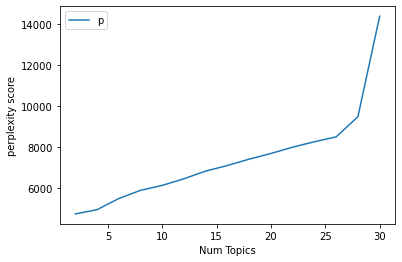

In [29]:
## import matplotlib.pyplot as plt

limit=32; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [23]:
count_vectorizer = CountVectorizer()
lda_count_vecs = count_vectorizer.fit_transform(lda_comments_joined)

count_lda = LatentDirichletAllocation(n_components=10, learning_method='online', n_jobs = 1)
lda_output = count_lda.fit_transform(lda_count_vecs)

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


visual = pyLDAvis.sklearn.prepare(count_lda, lda_count_vecs, count_vectorizer, mds='tsne')
visual

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\User\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https:/

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  16.483891
3       0.648955  71.707100       2        1  14.089712
2      71.019684   9.971006       3        1  12.749337
7       3.785981  33.185135       4        1  10.594362
8     -42.666500  -9.222070       5        1   9.655285
0      -3.621689 -43.526516       6        1   9.321249
9      -3.632402  -4.171708       7        1   8.219565
5     -36.584400  35.804413       8        1   6.738313
1      44.391380  50.615383       9        1   6.491466
4      40.235809 -31.591665      10        1   5.656820, topic_info=             Term          Freq         Total Category  logprob  loglift
62265       trump  33941.000000  33941.000000  Default  30.0000  30.0000
66664       white  13597.000000  13597.000000  Default  29.0000  29.0000
48939      racist   7850.000000   7850.000000  Default  28.0000  28.0000
6125        black   8432.000000   8432.000000  Default  27.0000  27.0000
67279       woman   8671.000000   8671.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
46689        post   1451.240257   4214.876064  Topic10  -4.8089   1.8061
34765       level    967.203218   1519.930154  Topic10  -5.2147   2.4203
16559  disgusting    949.412233   2418.724461  Topic10  -5.2332   1.9372
34016        land    870.622734   1315.090603  Topic10  -5.3199   2.4599
45874       place    943.183304   3114.437921  Topic10  -5.2398   1.6778

[542 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
418        2  0.998292   account
569        4  0.999563    action
591        2  0.704077  actually
591        3  0.295624  actually
760        2  0.999421     admit
...      ...       ...       ...
67967      4  0.098616      year
67967      5  0.231167      year
67967      9  0.052305      year
68029      1  0.662143       yes
68029      6  0.337721       yes

[770 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 3, 8, 9, 1, 10, 6, 2, 5])

In [19]:
lda_count_vecs

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<144334x68565 sparse matrix of type '<class 'numpy.int64'>'
	with 2826584 stored elements in Compressed Sparse Row format>